C:\Users\DELL\AppData\Local\Temp\ipykernel_13296\3248461157.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urgence[col_diagnostic_clean] = df_urgence[col_diagnostic_clean].apply(nettoyer_diagnostic)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13296\3248461157.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urgence['Diagnostic Catégorisé'] = df_urgence[col_diagnostic_clean].apply(categoriser_diagnostic)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13296\3248461157.py:259: SettingWithCopyWarni

Colonnes disponibles :
['N_ordre', "Date d'inclusion", 'Date de naissance', 'Âge du debut d etude en mois (en janvier 2023)', 'Sexe', 'Origine Géographique', 'Statut des parents (Vivants/Décédés)', 'Parents Salariés', 'Prise en charge', 'Scolarité', "Niveau d'instruction scolarité", 'PEV Complet', 'Vaccin contre pneumocoque', 'Vaccin contre méningocoque', 'Vaccin contre Les salmonelles', 'Type de drépanocytose', "Taux d'Hb (g/dL)", "% d'Hb F", "% d'Hb S", "% d'HB C", 'Nbre de GB (/mm3)', "% d'HB A2", 'Nbre de PLT (/mm3)', 'GsRh', 'Âge de début des signes (en mois)', 'Âge de découverte de la drépanocytose (en mois)', 'Circonstances Courants', 'Autres (nommer)', 'Âge début de suivi du traitement (en mois)', "L'hydroxyurée", 'Echange transfusionnelle', 'Prophylaxie à la pénicilline', "Nbre d'hospitalisations avant 2017", "Nbre d'hospitalisations entre 2017 et 2023", 'HDJ', 'CVO', 'Anémie', 'AVC', 'STA', 'Priapisme', 'Infections', 'Autres 1', 'Autre 2', 'COMPLICATIONS', 'COMORBIDITE', 'Nbr

C:\Users\DELL\AppData\Local\Temp\ipykernel_13296\3248461157.py:381: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  df[col] = df[col].fillna(df[col].mode()[0])


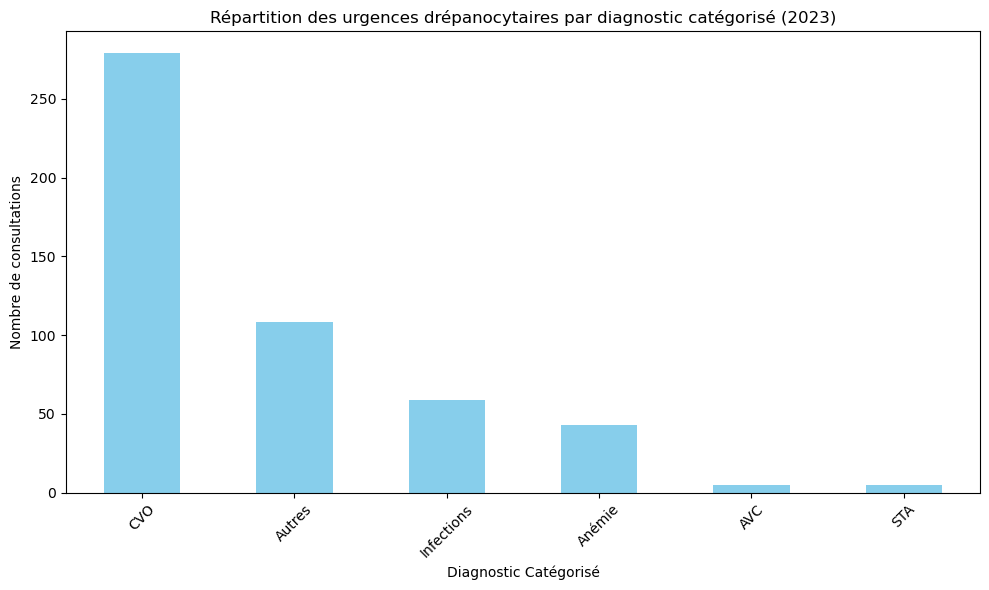

Données d’entraînement : 399 lignes
Données de test : 100 lignes


C:\Users\DELL\anaconda3\anaconda\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\DELL\anaconda3\anaconda\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\DELL\anaconda3\anaconda\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging
import re
import warnings

# Configurer le journal
logging.basicConfig(
    filename='analyse_donnees.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Fonction pour convertir Oui/Non en binaire
def oui_non_vers_binaire(valeur):
    if isinstance(valeur, str) and valeur.strip().lower() in ["oui", "o"]:
        return 1
    elif isinstance(valeur, str) and valeur.strip().lower() in ["non", "n"]:
        return 0
    return valeur

# Fonction pour convertir les colonnes Oui/Non d'un DataFrame en binaire
def convertir_df_oui_non(df, nom_feuille, exclude_columns=None):
    if df is None or df.empty:
        logging.warning(f"DataFrame vide pour la feuille '{nom_feuille}'")
        return df
    df = df.copy()
    exclude_columns = exclude_columns or []
    for col in df.columns:
        if col not in exclude_columns and df[col].isin(["Oui", "Non", "OUI", "NON", "oui", "non", "O", "N"]).any():
            logging.info(f"Conversion de Oui/Non en binaire pour la colonne '{col}' dans '{nom_feuille}'")
            df[col] = df[col].apply(oui_non_vers_binaire)
    return df

# Fonction pour nettoyer les labels de diagnostic
def nettoyer_diagnostic(diag):
    if not isinstance(diag, str):
        return diag
    nettoyé = re.sub(r'\s+', ' ', diag.strip()).upper()
    corrections = {
        'CVO OSSEUS E': 'CVO OSSEUSE', 'CVO OSSUSE': 'CVO OSSEUSE', 'AMYDALITE': 'AMYGDALITE',
        'AMYGDALITE ': 'AMYGDALITE', 'DOULEUR ABDOMINAL ': 'DOULEUR ABDOMINALE',
        ' DOULEUR ABDOMINAL': 'DOULEUR ABDOMINALE', 'RHINORHEE': 'RHINORRHEE',
        'RHINORRHEE ': 'RHINORRHEE', 'VOMISSIMENT': 'VOMISSEMENT', 'VOMISSEMENT ': 'VOMISSEMENT',
        'VOMISSEMENT  ': 'VOMISSEMENT', 'CEPHALEE ': 'CEPHALEE', ' CEPHALEE ': 'CEPHALEE',
        'MAL GORGE': 'MAL DE GORGE', 'MAUX GORGE': 'MAL DE GORGE'
    }
    return corrections.get(nettoyé, nettoyé)

# Fonction pour regrouper les diagnostics en catégories
def categoriser_diagnostic(diag):
    if not isinstance(diag, str):
        return 'Autres'
    diag = diag.upper()
    if 'CVO' in diag:
        return 'CVO'
    elif any(keyword in diag for keyword in ['AMYGDALITE', 'PHARYNGITE', 'RHINITE', 'RHINOPHARYNGITE', 'BRONCHITE', 'PNEUMONIE', 'SYNDROME INFECTIEUX', 'SYNDROME GRIPPAL']):
        return 'Infections'
    elif any(keyword in diag for keyword in ['ANEMIE', 'HEMOLYSE']):
        return 'Anémie'
    elif 'STA' in diag:
        return 'STA'
    elif 'AVCI' in diag or 'RECIDIVE AVCI' in diag:
        return 'AVC'
    else:
        return 'Autres'

# Ignorer les avertissements d'openpyxl
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Charger le fichier Excel
fichier = "C:/Users/DELL/Desktop/stage sante/Base_de_données_USAD_URGENCES1.xlsx"
try:
    feuilles = pd.read_excel(fichier, sheet_name=None)
    logging.info("Fichier Excel chargé avec succès.")
except Exception as e:
    logging.error(f"Erreur lors du chargement du fichier Excel : {e}")
    raise SystemExit(f"Erreur lors du chargement du fichier : {e}")

# Accéder aux feuilles
identité = feuilles.get('Identite')
drépanocytose = feuilles.get('Drépano')
antécédents = feuilles.get('Antéccédents')
urgence1 = feuilles.get('Urgence1')
urgence2 = feuilles.get('Urgence2')
urgence3 = feuilles.get('Urgence3')
urgence4 = feuilles.get('Urgence4')
urgence5 = feuilles.get('Urgence5')
urgence6 = feuilles.get('Urgence6')

# Vérifier la validité des feuilles
feuilles_urgences = [
    ('Urgence1', urgence1, 'DATE URGENCE 1', 'Hypothèses diagnostiques ou diagnostic positive', 'Evolution', 'Prise en charge Ambulatoire', 'Prise en charge HDJ', 'Prise en chargeHospitalisation'),
    ('Urgence2', urgence2, 'DATE URGENCE 2', 'Hypothèses diagnostiques ou diagnostic positive', 'Evolution', 'Prise en charge Ambulatoire', 'Prise en charge HDJ', 'Prise en chargeHospitalisation'),
    ('Urgence3', urgence3, 'DATE URGENCE 3', 'Hypothèses diagnostiques ou diagnostic positive', 'Evolution', 'Prise en charge Ambulatoire', 'Prise en charge HJD', 'Prise en chargeHospitalisation'),
    ('Urgence4', urgence4, 'DATE URGENCE 4', 'Hypothèses diagnostiques ou diagnostic positive', 'Evolution', 'Prise en chargeAmbulatoire', 'Prise en charge HJD', 'Prise en charge Hospitalisation'),
    ('Urgence5', urgence5, 'DateUrgence5', 'Hypothèses diagnostiques ou diagnostic positive', 'Evolution', 'Prise en charge Ambulatoire', 'Prise en charge HDJ', 'Prise en charge Hospitalisation'),
    ('Urgence6', urgence6, 'URGENCE 6', 'Hypothèses diagnostiques ou diagnostic positive', 'Evolution', 'Prise en charge Ambulatoire', 'Prise en charge HDJ', 'Prise en charge Hospitalisation')
]

# Convertir Oui/Non en binaire
identité = convertir_df_oui_non(identité, 'Identite', exclude_columns=['Niveau d\'instruction scolarité'])
drépanocytose = convertir_df_oui_non(drépanocytose, 'Drépano')
antécédents = convertir_df_oui_non(antécédents, 'Antéccédents')
for nom_urgence, df_urgence, _, _, _, _, _, _ in feuilles_urgences:
    if df_urgence is not None and not df_urgence.empty:
        df_urgence = convertir_df_oui_non(df_urgence, nom_urgence)

# Nettoyer les noms des colonnes
for df in [identité, drépanocytose, antécédents, urgence1, urgence2, urgence3, urgence4, urgence5, urgence6]:
    if isinstance(df, pd.DataFrame):
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = ['_'.join(col).strip() for col in df.columns.values]
        df.columns = df.columns.str.replace('\xa0', ' ').str.replace(r'\s+', ' ', regex=True).str.strip()
        logging.info(f"Noms des colonnes après nettoyage dans {df.name if hasattr(df, 'name') else 'feuille'}: {list(df.columns)}")

# Fonction pour trouver une colonne par correspondance partielle
def trouver_colonne(df, nom_partiel, nom_feuille):
    if df is None or df.empty:
        return None
    nom_partiel_normalisé = re.sub(r'\s+', ' ', nom_partiel.replace('\xa0', ' ').strip()).lower()
    for col in df.columns:
        col_normalisée = re.sub(r'\s+', ' ', str(col).replace('\xa0', ' ').strip()).lower()
        if nom_partiel_normalisé == col_normalisée or nom_partiel_normalisé in col_normalisée:
            logging.info(f"Colonne trouvée dans '{nom_feuille}' : '{col}' pour '{nom_partiel}'")
            return col
    logging.warning(f"Colonne non trouvée dans '{nom_feuille}' pour '{nom_partiel}'")
    return None

# Étape 1 : Fusionner Identite, Drépano et Antéccédents pour créer un DataFrame de base
df_base = identité.copy()
col_n_ordre = trouver_colonne(identité, 'N_ordre', 'Identite') or 'N_ordre'
if col_n_ordre not in identité.columns:
    logging.error("Colonne 'N_ordre' absente dans la feuille 'Identite'")
    raise SystemExit("Erreur : Colonne 'N_ordre' absente dans 'Identite'")

# Fusion avec Drépano
col_n_ordre_drepano = trouver_colonne(drépanocytose, 'N_ordre', 'Drépano') or 'N_ordre'
if col_n_ordre_drepano not in drépanocytose.columns:
    logging.error("Colonne 'N_ordre' absente dans la feuille 'Drépano'")
    raise SystemExit("Erreur : Colonne 'N_ordre' absente dans 'Drépano'")
df_base = df_base.merge(
    drépanocytose, how='left', left_on=col_n_ordre, right_on=col_n_ordre_drepano, suffixes=('', '_drepano')
)

# Fusion avec Antéccédents
col_n_ordre_antecedents = trouver_colonne(antécédents, 'N_ordre', 'Antéccédents') or 'N_ordre'
if col_n_ordre_antecedents not in antécédents.columns:
    logging.error("Colonne 'N_ordre' absente dans la feuille 'Antéccédents'")
    raise SystemExit("Erreur : Colonne 'N_ordre' absente dans 'Antéccédents'")
df_base = df_base.merge(
    antécédents, how='left', left_on=col_n_ordre, right_on=col_n_ordre_antecedents, suffixes=('', '_antecedents')
)

# Supprimer les colonnes N_ordre redondantes
colonnes_a_supprimer = [col for col in df_base.columns if col in [f'{col_n_ordre}_drepano', f'{col_n_ordre}_antecedents']]
df_base = df_base.drop(columns=colonnes_a_supprimer, errors='ignore')
logging.info(f"Colonnes supprimées dans df_base : {colonnes_a_supprimer}")

# Vérifier les colonnes après fusion
logging.info(f"Colonnes dans df_base : {list(df_base.columns)}")

# Étape 2 : Traiter les urgences et fusionner avec df_base
urgences_all = []
total_lignes = 0
colonnes_communes_urgences = [
    'N_ordre', 'Douleur', 'Fièvre', 'Pâleur', 'Ictère', 'Toux', 'Difficulté Respiratoire',
    'Convulsion', 'Impotence fonctionnelle', 'Syndrome pied main', 'Autres (à précisé)',
    'Splénomégalie', 'Souffle systolique fonctionnel', 'Douleur provoquée (Os,Abdomen)',
    'Evaluation de la douleur (EVA ou EVENDOL)', 'GR (/mm3)', 'HB (g/dl)', 'GB (/mm3)',
    'VGM (fl/u3)', 'TCMH (g/dl)', 'PLT (/mm3)', 'GE Oui ou Non', 'GE Positive', 'GE Négative',
    'CRP OUI OU NON', 'CRP Positive', 'CRP Négative', 'CRP Si positive (Valeur)',
    'Radiographie du thorax Oui ou Non', 'Radiographie du thorax (Si Oui) Résultats',
    'Echographie abdominale Oui ou Non', 'Echographie abdominale (Si Oui) Résultats',
    'Hypothèses diagnostiques ou diagnostic positive', 'Facteur causal',
    'Prise en charge Ambulatoire', 'Prise en charge HDJ', 'Prise en charge Hospitalisation', 'Evolution'
]

for nom_urgence, df_urgence, col_date, col_diagnostic, col_evolution, col_ambulatoire, col_hdj, col_hospitalisation in feuilles_urgences:
    if df_urgence is None or df_urgence.empty:
        logging.warning(f"Feuille '{nom_urgence}' est vide ou non valide")
        continue

    # Vérifier la colonne N_ordre
    col_n_ordre_urgence = trouver_colonne(df_urgence, 'N_ordre', nom_urgence) or 'N_ordre'
    if col_n_ordre_urgence not in df_urgence.columns:
        logging.error(f"Colonne 'N_ordre' absente dans '{nom_urgence}'. Ignorer cette feuille.")
        continue

    # Filtrer pour 2023
    col_date_clean = trouver_colonne(df_urgence, col_date, nom_urgence) or col_date
    if col_date_clean not in df_urgence.columns:
        logging.error(f"Colonne de date '{col_date_clean}' absente dans '{nom_urgence}'. Impossible de filtrer pour 2023.")
        raise SystemExit(f"Erreur : Colonne de date '{col_date_clean}' absente dans '{nom_urgence}'")
    
    df_urgence[col_date_clean] = pd.to_datetime(df_urgence[col_date_clean], errors='coerce')
    df_urgence = df_urgence[df_urgence[col_date_clean].dt.year == 2023]
    logging.info(f"Feuille '{nom_urgence}' après filtrage 2023 : {len(df_urgence)} lignes")

    if df_urgence.empty:
        logging.warning(f"Feuille '{nom_urgence}' vide après filtrage pour 2023")
        continue

    total_lignes += len(df_urgence)

    # Trouver les colonnes pertinentes
    col_diagnostic_clean = trouver_colonne(df_urgence, col_diagnostic, nom_urgence) or col_diagnostic
    col_evolution_clean = trouver_colonne(df_urgence, col_evolution, nom_urgence) or col_evolution
    col_ambulatoire_clean = trouver_colonne(df_urgence, col_ambulatoire, nom_urgence) or col_ambulatoire
    col_hdj_clean = trouver_colonne(df_urgence, col_hdj, nom_urgence) or col_hdj
    col_hospitalisation_clean = trouver_colonne(df_urgence, col_hospitalisation, nom_urgence) or col_hospitalisation

    # Symptômes et autres colonnes communes
    colonnes_map = {
        'Douleur': trouver_colonne(df_urgence, 'Douleur', nom_urgence),
        'Fièvre': trouver_colonne(df_urgence, 'Fièvre', nom_urgence) or trouver_colonne(df_urgence, 'Fièvre Motif de consultation', nom_urgence) or trouver_colonne(df_urgence, 'Fièvre de l\'examen Physique', nom_urgence),
        'Pâleur': trouver_colonne(df_urgence, 'Pâleur', nom_urgence),
        'Ictère': trouver_colonne(df_urgence, 'Ictère', nom_urgence),
        'Toux': trouver_colonne(df_urgence, 'Toux', nom_urgence),
        'Difficulté Respiratoire': trouver_colonne(df_urgence, 'Difficulté Respiratoire', nom_urgence),
        'Convulsion': trouver_colonne(df_urgence, 'Convulsion', nom_urgence),
        'Impotence fonctionnelle': trouver_colonne(df_urgence, 'Impotence fonctionnelle', nom_urgence),
        'Syndrome pied main': trouver_colonne(df_urgence, 'Syndrome pied main', nom_urgence) or trouver_colonne(df_urgence, 'Syndrome pied main Motif de consultation', nom_urgence) or trouver_colonne(df_urgence, 'Syndrome pied main de l\'examen Physique', nom_urgence),
        'Splénomégalie': trouver_colonne(df_urgence, 'Splénomégalie', nom_urgence),
        'Souffle systolique fonctionnel': trouver_colonne(df_urgence, 'Souffle systolique fonctionnel', nom_urgence) or trouver_colonne(df_urgence, 'Souffle systolique ORGANIQUE', nom_urgence),
        'Douleur provoquée (Os,Abdomen)': trouver_colonne(df_urgence, 'Douleur provoquée (Os,Abdomen)', nom_urgence) or trouver_colonne(df_urgence, 'Douleur (Os,Abdomen ...)', nom_urgence),
        'Evaluation de la douleur (EVA ou EVENDOL)': trouver_colonne(df_urgence, 'Evaluation de la douleur (EVA ou EVENDOL)', nom_urgence),
        'GR (/mm3)': trouver_colonne(df_urgence, 'GR (/mm3)', nom_urgence),
        'HB (g/dl)': trouver_colonne(df_urgence, 'HB (g/dl)', nom_urgence),
        'GB (/mm3)': trouver_colonne(df_urgence, 'GB (/mm3)', nom_urgence),
        'VGM (fl/u3)': trouver_colonne(df_urgence, 'VGM (fl/u3)', nom_urgence),
        'TCMH (g/dl)': trouver_colonne(df_urgence, 'TCMH (g/dl)', nom_urgence),
        'PLT (/mm3)': trouver_colonne(df_urgence, 'PLT (/mm3)', nom_urgence),
        'GE Oui ou Non': trouver_colonne(df_urgence, 'GE Oui ou Non', nom_urgence) or trouver_colonne(df_urgence, 'GE OUI ou NON', nom_urgence),
        'GE Positive': trouver_colonne(df_urgence, 'GE Positive', nom_urgence),
        'GE Négative': trouver_colonne(df_urgence, 'GE Négative', nom_urgence),
        'CRP OUI OU NON': trouver_colonne(df_urgence, 'CRP OUI OU NON', nom_urgence) or trouver_colonne(df_urgence, 'CRP OUI / NON', nom_urgence),
        'CRP Positive': trouver_colonne(df_urgence, 'CRP Positive', nom_urgence),
        'CRP Négative': trouver_colonne(df_urgence, 'CRP Négative', nom_urgence),
        'CRP Si positive (Valeur)': trouver_colonne(df_urgence, 'CRP Si positive (Valeur)', nom_urgence) or trouver_colonne(df_urgence, 'Si positive (Valeur)', nom_urgence),
        'Radiographie du thorax Oui ou Non': trouver_colonne(df_urgence, 'Radiographie du thorax Oui ou Non', nom_urgence),
        'Radiographie du thorax (Si Oui) Résultats': trouver_colonne(df_urgence, 'Radiographie du thorax (Si Oui) Résultats', nom_urgence),
        'Echographie abdominale Oui ou Non': trouver_colonne(df_urgence, 'Echographie abdominale Oui ou Non', nom_urgence),
        'Echographie abdominale (Si Oui) Résultats': trouver_colonne(df_urgence, 'Echographie abdominale (Si Oui) Résultats', nom_urgence),
        'Facteur causal': trouver_colonne(df_urgence, 'Facteur causal', nom_urgence)
    }

    # Nettoyer les diagnostics
    if col_diagnostic_clean in df_urgence.columns:
        df_urgence[col_diagnostic_clean] = df_urgence[col_diagnostic_clean].apply(nettoyer_diagnostic)
        df_urgence['Diagnostic Catégorisé'] = df_urgence[col_diagnostic_clean].apply(categoriser_diagnostic)

    # Ajouter le mois
    if col_date_clean in df_urgence.columns:
        df_urgence['Mois'] = df_urgence[col_date_clean].dt.strftime('%B')

    # Ajouter le niveau d’urgence
    df_urgence['NiveauUrgence'] = nom_urgence

    # Sélectionner les colonnes communes
    colonnes_urgence = [col_n_ordre_urgence, 'Mois', 'Diagnostic Catégorisé', 'NiveauUrgence']
    for col_name, col_mapped in colonnes_map.items():
        if col_mapped in df_urgence.columns:
            colonnes_urgence.append(col_mapped)
    if col_evolution_clean in df_urgence.columns:
        colonnes_urgence.append(col_evolution_clean)
    if col_ambulatoire_clean in df_urgence.columns:
        colonnes_urgence.append(col_ambulatoire_clean)
    if col_hdj_clean in df_urgence.columns:
        colonnes_urgence.append(col_hdj_clean)
    if col_hospitalisation_clean in df_urgence.columns:
        colonnes_urgence.append(col_hospitalisation_clean)

    df_urgence = df_urgence[colonnes_urgence].rename(columns={
        col_n_ordre_urgence: 'N_ordre',
        col_diagnostic_clean: 'Hypothèses diagnostiques ou diagnostic positive',
        col_evolution_clean: 'Evolution',
        col_ambulatoire_clean: 'Prise en charge Ambulatoire',
        col_hdj_clean: 'Prise en charge HDJ',
        col_hospitalisation_clean: 'Prise en charge Hospitalisation',
        **{col_mapped: col_name for col_name, col_mapped in colonnes_map.items() if col_mapped in df_urgence.columns}
    })

    # Réinitialiser l'index avant la jointure
    df_urgence = df_urgence.reset_index(drop=True)
    logging.info(f"Index réinitialisé pour '{nom_urgence}' : {len(df_urgence)} lignes")

    # Fusionner avec df_base
    df_merged = df_base.merge(
        df_urgence, how='right', left_on=col_n_ordre, right_on='N_ordre', suffixes=('_base', '')
    )

    # Supprimer les colonnes N_ordre redondantes
    colonnes_a_supprimer = [col for col in df_merged.columns if col.endswith('_base') and col != 'N_ordre']
    df_merged = df_merged.drop(columns=colonnes_a_supprimer, errors='ignore')
    logging.info(f"Colonnes supprimées après jointure pour '{nom_urgence}' : {colonnes_a_supprimer}")

    # Réorganiser les colonnes pour placer celles de Identite, Drépano, Antéccédents en premier
    colonnes_identite = [col for col in df_merged.columns if col in identité.columns and col != col_n_ordre]
    colonnes_drepano = [col for col in df_merged.columns if col in drépanocytose.columns and col != col_n_ordre_drepano]
    colonnes_antecedents = [col for col in df_merged.columns if col in antécédents.columns and col != col_n_ordre_antecedents]
    colonnes_urgences = [col for col in df_merged.columns if col not in colonnes_identite + colonnes_drepano + colonnes_antecedents + ['N_ordre']]

    # Définir l'ordre des colonnes
    colonnes_finales = ['N_ordre'] + colonnes_identite + colonnes_drepano + colonnes_antecedents + colonnes_urgences
    df_merged = df_merged[colonnes_finales]

    # Vérifier les colonnes après jointure
    logging.info(f"Colonnes après jointure pour '{nom_urgence}' : {list(df_merged.columns)}")

    # Vérifier les index dupliqués
    if df_merged.index.duplicated().any():
        logging.warning(f"Index dupliqués détectés dans '{nom_urgence}' après jointure. Réinitialisation de l'index.")
        df_merged = df_merged.reset_index(drop=True)

    # Vérifier les colonnes en double
    colonnes_dupliquees = df_merged.columns[df_merged.columns.duplicated()].tolist()
    if colonnes_dupliquees:
        logging.error(f"Colonnes dupliquées dans '{nom_urgence}' : {colonnes_dupliquees}")
        raise SystemExit(f"Erreur : Colonnes dupliquées dans '{nom_urgence}' : {colonnes_dupliquees}")

    urgences_all.append(df_merged)

# Vérifier et concaténer
if not urgences_all:
    logging.error("Aucune donnée d’urgence disponible pour 2023 dans les feuilles.")
    raise SystemExit("Erreur : Aucune donnée d’urgence disponible pour 2023. Vérifiez les feuilles Urgence1 à Urgence6.")

# Vérifier les colonnes avant concaténation
for i, df in enumerate(urgences_all):
    logging.info(f"Colonnes dans urgences_all[{i}] : {list(df.columns)}")

urgences_final = pd.concat(urgences_all, ignore_index=True)
logging.info(f"Total urgences collectées : {len(urgences_final)}")

# Vérifier le total
if len(urgences_final) != 499:
    logging.error(f"Nombre d'urgences ({len(urgences_final)}) différent de 499 attendu.")
    raise SystemExit(f"Erreur : Nombre d'urgences ({len(urgences_final)}) différent de 499. Vérifiez les dates dans les feuilles Urgence1 à Urgence6.")

# Renommer les colonnes pour cohérence
urgences_final = urgences_final.rename(columns={
    'Hypothèses diagnostiques ou diagnostic positive': 'Diagnostic'
})

# Exporter en Excel
urgences_final.to_excel('urgences_drepanocytaires_2023.xlsx', sheet_name='Urgences_2023', index=False, engine='openpyxl')
logging.info(f"Fichier Excel exporté : urgences_drepanocytaires_2023.xlsx avec {len(urgences_final)} lignes")

# --- Analyse et modélisation ---

# Charger le fichier consolidé
try:
    df = pd.read_excel('urgences_drepanocytaires_2023.xlsx', sheet_name='Urgences_2023')
    logging.info(f"Fichier consolidé chargé : {len(df)} consultations pour 231 patients")
except Exception as e:
    logging.error(f"Erreur lors du chargement du fichier consolidé : {e}")
    raise SystemExit(f"Erreur : {e}")

# Vérifier le nombre de consultations
if len(df) != 499:
    logging.error(f"Nombre de consultations ({len(df)}) différent de 499")
    raise SystemExit(f"Erreur : {len(df)} consultations au lieu de 499")

# Étape 1 : Afficher les colonnes disponibles
colonnes_disponibles = df.columns.tolist()
logging.info(f"Colonnes disponibles pour analyse : {colonnes_disponibles}")
print("Colonnes disponibles :")
print(colonnes_disponibles)

# Étape 2 : Gestion des valeurs manquantes
for col in df.columns:
    if col != 'N_ordre':  # Exclure N_ordre de l'imputation
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
logging.info("Valeurs manquantes imputées")
print("Valeurs manquantes après imputation :")
print(df.isnull().sum())

# Étape 3 : Vérification des diagnostics catégorisés
col_diag = 'Diagnostic Catégorisé'
valid_categories = ['CVO', 'Infections', 'Anémie', 'STA', 'AVC', 'Autres']
if col_diag in df.columns:
    df[col_diag] = df[col_diag].str.strip()
    if not df[col_diag].isin(valid_categories).all():
        logging.warning(f"Diagnostics inattendus : {df[col_diag].unique()}")
    # Analyse simple des diagnostics
    diagnostic_counts = df[col_diag].value_counts()
    print("\nRépartition des diagnostics catégorisés (499 consultations) :")
    print(diagnostic_counts)
else:
    logging.error(f"Colonne {col_diag} absente")
    raise SystemExit(f"Erreur : Colonne {col_diag} absente")

# Étape 4 : Visualisation des diagnostics
# Créer un graphique en barres avec Chart.js
chart_data = {
    "type": "bar",
    "data": {
        "labels": diagnostic_counts.index.tolist(),
        "datasets": [{
            "label": "Nombre de consultations",
            "data": diagnostic_counts.values.tolist(),
            "backgroundColor": ["#36A2EB", "#FF6384", "#FFCE56", "#4BC0C0", "#9966FF", "#FF9F40"],
            "borderColor": ["#2E8BC0", "#D81B60", "#FBC02D", "#3AA6A0", "#7B3FE4", "#F57C00"],
            "borderWidth": 1
        }]
    },
    "options": {
        "scales": {
            "y": {
                "beginAtZero": True,
                "title": {
                    "display": True,
                    "text": "Nombre de consultations"
                }
            },
            "x": {
                "title": {
                    "display": True,
                    "text": "Diagnostic Catégorisé"
                }
            }
        },
        "plugins": {
            "title": {
                "display": True,
                "text": "Répartition des urgences drépanocytaires par diagnostic catégorisé (2023)"
            },
            "legend": {
                "display": False
            }
        }
    }
}

print("\nGraphique généré : Répartition des diagnostics catégorisés")
# Sauvegarde avec matplotlib comme solution de secours
diagnostic_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Répartition des urgences drépanocytaires par diagnostic catégorisé (2023)')
plt.xlabel('Diagnostic Catégorisé')
plt.ylabel('Nombre de consultations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graphique_diagnostic.png', dpi=300, bbox_inches='tight')
plt.show()

# Étape 5 : Préparation pour la modélisation
# Supprimer N_ordre pour la modélisation
if 'N_ordre' in df.columns:
    df = df.drop(columns=['N_ordre'])

# Encoder les variables catégoriques
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)

# Normalisation des variables numériques
scaler = StandardScaler()
colonnes_numeriques = df_encoded.select_dtypes(include=['int64', 'float64']).columns
df_encoded[colonnes_numeriques] = scaler.fit_transform(df_encoded[colonnes_numeriques])

# Division en ensembles d’entraînement (80 %) et de test (20 %)
col_cible = 'Evolution'
if col_cible in df.columns:
    X = df_encoded.drop(columns=[col_cible], errors='ignore')
    y = df[col_cible]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logging.info(f"Données divisées : {len(X_train)} lignes pour l’entraînement, {len(X_test)} lignes pour le test")
    print(f"Données d’entraînement : {len(X_train)} lignes")
    print(f"Données de test : {len(X_test)} lignes")
else:
    logging.warning(f"Colonne {col_cible} absente. Modélisation non effectuée.")
    print(f"Colonne {col_cible} absente. Sélectionnez une autre variable cible pour la modélisation.")

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
import logging

# Configurer le journal
logging.basicConfig(
    filename='analyse_donnees.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Charger le fichier consolidé
fichier = 'urgences_drepanocytaires_2023.xlsx'
try:
    df = pd.read_excel(fichier, sheet_name='Urgences_2023')
    logging.info(f"Fichier consolidé chargé : {len(df)} consultations à {pd.Timestamp.now()}")
except Exception as e:
    logging.error(f"Erreur lors du chargement du fichier : {e} à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {e}")

# Vérifier le nombre total de consultations
if len(df) != 499:
    logging.error(f"Nombre de consultations ({len(df)}) différent de 499 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {len(df)} consultations au lieu de 499")

# Vérifier le nombre total de patients
nb_patients_total = df['N_ordre'].nunique()
logging.info(f"Nombre total de patients (N_ordre unique) : {nb_patients_total} à {pd.Timestamp.now()}")
if nb_patients_total != 231:
    logging.error(f"Nombre de patients ({nb_patients_total}) différent de 231 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {nb_patients_total} patients au lieu de 231")

# Préparation des données
# Supprimer N_ordre (identifiant, non pertinent pour la modélisation)
df = df.drop(columns=['N_ordre'], errors='ignore')

# Variable cible
col_cible = 'Evolution'
if col_cible not in df.columns:
    logging.error(f"Colonne {col_cible} absente à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : Colonne {col_cible} absente")


# Encoder les variables catégoriques
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != col_cible:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Encoder la variable cible si elle est catégorique
if df_encoded[col_cible].dtype == 'object':
    le_cible = LabelEncoder()
    df_encoded[col_cible] = le_cible.fit_transform(df_encoded[col_cible].astype(str))
    label_encoders[col_cible] = le_cible
logging.info(f"Variables catégoriques encodées à {pd.Timestamp.now()}")

# Séparer les features et la cible
X = df_encoded.drop(columns=[col_cible])
y = df_encoded[col_cible]

# --- Méthode 1 : Sélection basée sur la corrélation ---
# Pour les variables numériques : coefficient de corrélation de Pearson
corr_scores = {}
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    if X[col].notna().all() and y.notna().all():  # Vérifier absence de NaN
        corr, _ = pearsonr(X[col].values, y.values)
        corr_scores[col] = abs(corr)
    else:
        logging.warning(f"Colonne {col} ou y contient des NaN, corrélation ignorée à {pd.Timestamp.now()}")
logging.info(f"Corrélations de Pearson calculées à {pd.Timestamp.now()}")

# Pour les variables catégoriques : test du chi²
chi2_scores = {}
X_cat = X.select_dtypes(include=['object', 'int64']).copy()
for col in X_cat.columns:
    if X_cat[col].dtype == 'object':
        X_cat[col] = LabelEncoder().fit_transform(X_cat[col].astype(str))
chi2_vals, p_vals = chi2(X_cat, y)
for col, chi2_val in zip(X_cat.columns, chi2_vals):
    chi2_scores[col] = chi2_val
logging.info(f"Scores Chi² calculés à {pd.Timestamp.now()}")

# Combiner les scores (normaliser pour comparaison)
max_corr = max(corr_scores.values(), default=0)
max_chi2 = max(chi2_scores.values(), default=0)
combined_scores = {}
for col in corr_scores:
    combined_scores[col] = corr_scores[col] / max_corr if max_corr > 0 else 0
for col in chi2_scores:
    combined_scores[col] = chi2_scores[col] / max_chi2 if max_chi2 > 0 else 0

# Sélectionner les 10 meilleures variables
top_corr_features = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:10]
logging.info(f"Top 10 variables (corrélation/chi²) : {top_corr_features} à {pd.Timestamp.now()}")
print("\nMéthode 1 : Sélection basée sur la corrélation/chi²")
print("Top 10 variables :")
for feature, score in top_corr_features:
    print(f"{feature}: {score:.3f}")

# --- Méthode 2 : Sélection basée sur Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
rf_scores = {col: importance for col, importance in zip(X.columns, importances)}

# Sélectionner les 10 meilleures variables
top_rf_features = sorted(rf_scores.items(), key=lambda x: x[1], reverse=True)[:10]
logging.info(f"Top 10 variables (Random Forest) : {top_rf_features} à {pd.Timestamp.now()}")
print("\nMéthode 2 : Sélection basée sur Random Forest")
print("Top 10 variables :")
for feature, score in top_rf_features:
    print(f"{feature}: {score:.3f}")

# Sauvegarder les résultats pour le rapport
resultats_selection = pd.DataFrame({
    'Variable': [x[0] for x in top_corr_features] + [x[0] for x in top_rf_features],
    'Score': [x[1] for x in top_corr_features] + [x[1] for x in top_rf_features],
    'Méthode': ['Corrélation/Chi²']*10 + ['Random Forest']*10
})
resultats_selection.to_excel('resultats_selection_variables.xlsx', index=False)
logging.info(f"Résultats de sélection des variables exportés : resultats_selection_variables.xlsx à {pd.Timestamp.now()}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_17712\2525261981.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(X[col].values, y.values)



Méthode 1 : Sélection basée sur la corrélation/chi²
Top 10 variables :
Nbre d'hospitalisations avant 2017: 1.000
Nbre de transfusion Entre 2017 et 2023: 0.953
HDJ: 0.696
Pâleur: 0.538
Convulsion: nan
Splénomégalie: 0.793
Prise en charge HDJ: 0.463
Prise en charge Ambulatoire: 0.459
Âge du debut d etude en mois (en janvier 2023): 0.423
Parents Salariés: 0.337

Méthode 2 : Sélection basée sur Random Forest
Top 10 variables :
HB (g/dl): 0.045
Mois: 0.040
PLT (/mm3): 0.036
GR (/mm3): 0.032
Nbre de GB (/mm3): 0.031
Nbre de PLT (/mm3): 0.031
Date d'inclusion: 0.030
TCMH (g/dl): 0.028
GB (/mm3): 0.028
Âge de découverte de la drépanocytose (en mois): 0.027


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
import logging

# Configurer le journal
logging.basicConfig(
    filename='analyse_donnees.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Charger le fichier consolidé
fichier = 'urgences_drepanocytaires_2023.xlsx'
try:
    df = pd.read_excel(fichier, sheet_name='Urgences_2023')
    logging.info(f"Fichier consolidé chargé : {len(df)} consultations à {pd.Timestamp.now()}")
except Exception as e:
    logging.error(f"Erreur lors du chargement du fichier : {e} à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {e}")

# Vérifier le nombre total de consultations
if len(df) != 499:
    logging.error(f"Nombre de consultations ({len(df)}) différent de 499 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {len(df)} consultations au lieu de 499")

# Vérifier le nombre total de patients
nb_patients_total = df['N_ordre'].nunique()
logging.info(f"Nombre total de patients (N_ordre unique) : {nb_patients_total} à {pd.Timestamp.now()}")
if nb_patients_total != 231:
    logging.error(f"Nombre de patients ({nb_patients_total}) différent de 231 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {nb_patients_total} patients au lieu de 231")

# Préparation des données
# Supprimer N_ordre (identifiant, non pertinent pour la modélisation)
df = df.drop(columns=['N_ordre'], errors='ignore')

# Variable cible
col_cible = 'Evolution'
if col_cible not in df.columns:
    logging.error(f"Colonne {col_cible} absente à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : Colonne {col_cible} absente")


# Encoder les variables catégoriques
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != col_cible:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Encoder la variable cible si elle est catégorique
if df_encoded[col_cible].dtype == 'object':
    le_cible = LabelEncoder()
    df_encoded[col_cible] = le_cible.fit_transform(df_encoded[col_cible].astype(str))
    label_encoders[col_cible] = le_cible
logging.info(f"Variables catégoriques encodées à {pd.Timestamp.now()}")

# Séparer les features et la cible
X = df_encoded.drop(columns=[col_cible])
y = df_encoded[col_cible]

# --- Méthode 1 : Sélection basée sur la significativité (corrélation) ---
# Pour les variables numériques : coefficient de corrélation de Pearson avec p-value
corr_scores = {}
corr_p_values = {}
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    if X[col].notna().all() and y.notna().all():  # Vérifier absence de NaN
        corr, p_value = pearsonr(X[col].values, y.values)
        corr_scores[col] = abs(corr)
        corr_p_values[col] = p_value
    else:
        logging.warning(f"Colonne {col} ou y contient des NaN, corrélation ignorée à {pd.Timestamp.now()}")
logging.info(f"Corrélations de Pearson calculées à {pd.Timestamp.now()}")

# Pour les variables catégoriques : test du chi² avec p-value
chi2_scores = {}
chi2_p_values = {}
X_cat = X.select_dtypes(include=['object', 'int64']).copy()
for col in X_cat.columns:
    if X_cat[col].dtype == 'object':
        X_cat[col] = LabelEncoder().fit_transform(X_cat[col].astype(str))
chi2_vals, chi2_p_vals = chi2(X_cat, y)
for col, chi2_val, p_val in zip(X_cat.columns, chi2_vals, chi2_p_vals):
    chi2_scores[col] = chi2_val
    chi2_p_values[col] = p_val
logging.info(f"Scores Chi² calculés à {pd.Timestamp.now()}")

# Sélectionner les variables significatives (p-value < 0.05)
significant_corr_features = {col: score for col, score in corr_scores.items() if col in corr_p_values and corr_p_values[col] < 0.05}
significant_chi2_features = {col: score for col, score in chi2_scores.items() if col in chi2_p_values and chi2_p_values[col] < 0.05}
significant_features_corr = {**significant_corr_features, **significant_chi2_features}

logging.info(f"Variables significatives (corrélation/chi²) : {significant_features_corr} à {pd.Timestamp.now()}")
print("\nMéthode 1 : Sélection basée sur la significativité (corrélation/chi²)")
print("Variables significatives (p-value < 0.05) :")
for feature, score in significant_features_corr.items():
    p_value = corr_p_values.get(feature, chi2_p_values.get(feature, "N/A"))
    print(f"{feature}: Score = {score:.3f}, p-value = {p_value:.3f}")

# --- Méthode 2 : Sélection basée sur Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
rf_scores = {col: importance for col, importance in zip(X.columns, importances)}

# Sélectionner les variables avec importance non nulle
significant_rf_features = {col: score for col, score in rf_scores.items() if score > 0}

logging.info(f"Variables significatives (Random Forest) : {significant_rf_features} à {pd.Timestamp.now()}")
print("\nMéthode 2 : Sélection basée sur Random Forest")
print("Variables avec importance non nulle :")
for feature, score in significant_rf_features.items():
    print(f"{feature}: Importance = {score:.3f}")

# Sauvegarder les résultats pour le rapport
resultats_selection = pd.DataFrame({
    'Variable': list(significant_features_corr.keys()) + list(significant_rf_features.keys()),
    'Score': list(significant_features_corr.values()) + list(significant_rf_features.values()),
    'p-value' if 'p-value' not in significant_rf_features else 'Importance': ['p-value']*len(significant_features_corr) + ['Importance']*len(significant_rf_features),
    'Méthode': ['Corrélation/Chi²']*len(significant_features_corr) + ['Random Forest']*len(significant_rf_features)
})
resultats_selection.to_excel('resultats_selection_variables_significatives.xlsx', index=False)
logging.info(f"Résultats de sélection des variables exportés : resultats_selection_variables_significatives.xlsx à {pd.Timestamp.now()}")

C:\Users\DELL\AppData\Local\Temp\ipykernel_17712\4021620684.py:74: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(X[col].values, y.values)



Méthode 1 : Sélection basée sur la significativité (corrélation/chi²)
Variables significatives (p-value < 0.05) :
Parents Salariés: Score = 0.106, p-value = 0.018
Vaccin contre pneumocoque: Score = 0.128, p-value = 0.004
Vaccin contre méningocoque: Score = 0.108, p-value = 0.016
HDJ: Score = 5.113, p-value = 0.032
Pâleur: Score = 5.785, p-value = 0.012
Splénomégalie: Score = 8.633, p-value = 0.003
Prise en charge Ambulatoire: Score = 0.090, p-value = 0.044
Prise en charge Hospitalisation: Score = 18.950, p-value = 0.000
Nbre d'hospitalisations avant 2017: Score = 4.798, p-value = 0.138

Méthode 2 : Sélection basée sur Random Forest
Variables avec importance non nulle :
Date d'inclusion: Importance = 0.024
Date de naissance: Importance = 0.027
Âge du debut d etude en mois (en janvier 2023): Importance = 0.029
Sexe: Importance = 0.003
Origine Géographique: Importance = 0.007
Statut des parents (Vivants/Décédés): Importance = 0.000
Parents Salariés: Importance = 0.007
Prise en charge: Im

In [15]:
print(df.isnull().sum())
print(df['Evolution'].unique())

Date d'inclusion                                    0
Date de naissance                                   0
Âge du debut d etude en mois (en janvier 2023)      0
Sexe                                                0
Origine Géographique                                0
                                                 ... 
Facteur causal                                    477
Prise en charge Ambulatoire                         0
Prise en charge HDJ                                 0
Prise en charge Hospitalisation                     0
Evolution                                           0
Length: 84, dtype: int64
['Favorable' 'Complications']


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
import logging

# Configurer le journal
logging.basicConfig(
    filename='analyse_donnees.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Charger le fichier consolidé
fichier = 'urgences_drepanocytaires_2023.xlsx'
try:
    df = pd.read_excel(fichier, sheet_name='Urgences_2023')
    logging.info(f"Fichier consolidé chargé : {len(df)} consultations à {pd.Timestamp.now()}")
    print(f"Nombre de colonnes initial : {df.shape[1]}")
except Exception as e:
    logging.error(f"Erreur lors du chargement du fichier : {e} à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {e}")

# Vérifier le nombre total de consultations
if len(df) != 499:
    logging.error(f"Nombre de consultations ({len(df)}) différent de 499 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {len(df)} consultations au lieu de 499")

# Vérifier le nombre total de patients
nb_patients_total = df['N_ordre'].nunique()
logging.info(f"Nombre total de patients (N_ordre unique) : {nb_patients_total} à {pd.Timestamp.now()}")
if nb_patients_total != 231:
    logging.error(f"Nombre de patients ({nb_patients_total}) différent de 231 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {nb_patients_total} patients au lieu de 231")

# Préparation des données
# Supprimer N_ordre et Facteur causal (trop de valeurs manquantes)
df = df.drop(columns=['N_ordre', 'Facteur causal', 'Autres (nommer)', 'Autres 1'], errors='ignore')
print(f"Nombre de colonnes après suppression de N_ordre et Facteur causal : {df.shape[1]}")

# Variable cible
col_cible = 'Evolution'
if col_cible not in df.columns:
    logging.error(f"Colonne {col_cible} absente à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : Colonne {col_cible} absente")



# Gérer les valeurs manquantes et infinies pour les features
for col in df.columns:
    if col != col_cible:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
logging.info(f"Valeurs manquantes et infinies imputées à {pd.Timestamp.now()}")

#
# Encoder les variables catégoriques
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != col_cible:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Encoder la variable cible
if df_encoded[col_cible].dtype == 'object':
    le_cible = LabelEncoder()
    df_encoded[col_cible] = le_cible.fit_transform(df_encoded[col_cible].astype(str))
    label_encoders[col_cible] = le_cible
logging.info(f"Variables catégoriques encodées à {pd.Timestamp.now()}")

# Séparer les features et la cible
X = df_encoded.drop(columns=[col_cible])
y = df_encoded[col_cible]
print(f"Nombre de colonnes dans X (features) après encodage : {X.shape[1]}")

# --- Méthode 1 : Sélection basée sur la significativité (corrélation/chi²) ---
# Pour les variables numériques : coefficient de corrélation de Pearson avec p-value
corr_scores = {}
corr_p_values = {}
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    if X[col].notna().all() and y.notna().all():
        corr, p_value = pearsonr(X[col].values, y.values)
        corr_scores[col] = abs(corr)
        corr_p_values[col] = p_value
    else:
        logging.warning(f"Colonne {col} ou y contient des NaN, corrélation ignorée à {pd.Timestamp.now()}")
logging.info(f"Corrélations de Pearson calculées à {pd.Timestamp.now()}")

# Pour les variables catégoriques : test du chi² avec p-value
chi2_scores = {}
chi2_p_values = {}
X_cat = X.select_dtypes(include=['object', 'int64']).copy()
for col in X_cat.columns:
    if X_cat[col].dtype == 'object':
        X_cat[col] = LabelEncoder().fit_transform(X_cat[col].astype(str))
chi2_vals, chi2_p_vals = chi2(X_cat, y)
for col, chi2_val, p_val in zip(X_cat.columns, chi2_vals, chi2_p_vals):
    chi2_scores[col] = chi2_val
    chi2_p_values[col] = p_val
logging.info(f"Scores Chi² calculés à {pd.Timestamp.now()}")

# Sélectionner les variables significatives (p-value < 0.05)
significant_corr_features = {col: score for col, score in corr_scores.items() if col in corr_p_values and corr_p_values[col] < 0.05}
significant_chi2_features = {col: score for col, score in chi2_scores.items() if col in chi2_p_values and chi2_p_values[col] < 0.05}
significant_features_corr = {**significant_corr_features, **significant_chi2_features}

logging.info(f"Variables significatives (corrélation/chi²) : {significant_features_corr} à {pd.Timestamp.now()}")
print("\nMéthode 1 : Sélection basée sur la significativité (corrélation/chi²)")
print("Variables significatives (p-value < 0.05) :")
for feature, score in significant_features_corr.items():
    p_value = corr_p_values.get(feature, chi2_p_values.get(feature, "N/A"))
    print(f"{feature}: Score = {score:.3f}, p-value = {p_value:.3f}")

# --- Méthode 2 : Sélection basée sur Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
rf_scores = {col: importance for col, importance in zip(X.columns, importances)}

# Sélectionner les variables avec importance > 0.01 (seuil ajusté)
significant_rf_features = {col: score for col, score in rf_scores.items() if score > 0.01}

logging.info(f"Variables significatives (Random Forest, importance > 0.01) : {significant_rf_features} à {pd.Timestamp.now()}")
print("\nMéthode 2 : Sélection basée sur Random Forest")
print("Variables avec importance > 0.01 :")
for feature, score in significant_rf_features.items():
    print(f"{feature}: Importance = {score:.3f}")

# Sauvegarder les résultats pour le rapport
resultats_selection = pd.DataFrame({
    'Variable': list(significant_features_corr.keys()) + list(significant_rf_features.keys()),
    'Score': list(significant_features_corr.values()) + list(significant_rf_features.values()),
    'p-value' if 'p-value' not in significant_rf_features else 'Importance': ['p-value']*len(significant_features_corr) + ['Importance']*len(significant_rf_features),
    'Méthode': ['Corrélation/Chi²']*len(significant_features_corr) + ['Random Forest']*len(significant_rf_features)
})
resultats_selection.to_excel('resultats_selection_variables_significatives.xlsx', index=False)
logging.info(f"Résultats de sélection des variables exportés : resultats_selection_variables_significatives.xlsx à {pd.Timestamp.now()}")

Nombre de colonnes initial : 85
Nombre de colonnes après suppression de N_ordre et Facteur causal : 81
Nombre de colonnes dans X (features) après encodage : 80


C:\Users\DELL\AppData\Local\Temp\ipykernel_17712\2549445498.py:58: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  df[col] = df[col].fillna(df[col].mode()[0])
C:\Users\DELL\AppData\Local\Temp\ipykernel_17712\2549445498.py:89: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(X[col].values, y.values)



Méthode 1 : Sélection basée sur la significativité (corrélation/chi²)
Variables significatives (p-value < 0.05) :
Parents Salariés: Score = 0.106, p-value = 0.018
Vaccin contre pneumocoque: Score = 0.128, p-value = 0.004
Vaccin contre méningocoque: Score = 0.108, p-value = 0.016
Nbre de PLT (/mm3): Score = 0.094, p-value = 0.036
HDJ: Score = 5.113, p-value = 0.032
Pâleur: Score = 5.785, p-value = 0.012
Splénomégalie: Score = 8.633, p-value = 0.003
HB (g/dl): Score = 0.098, p-value = 0.029
CRP OUI OU NON: Score = 0.089, p-value = 0.046
Prise en charge Ambulatoire: Score = 0.090, p-value = 0.044
Prise en charge Hospitalisation: Score = 18.950, p-value = 0.000
Nbre d'hospitalisations avant 2017: Score = 4.798, p-value = 0.138

Méthode 2 : Sélection basée sur Random Forest
Variables avec importance > 0.01 :
Date d'inclusion: Importance = 0.021
Date de naissance: Importance = 0.025
Âge du debut d etude en mois (en janvier 2023): Importance = 0.027
Vaccin contre pneumocoque: Importance = 0.

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
import logging

# Configurer le journal
logging.basicConfig(
    filename='analyse_donnees.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Charger le fichier consolidé
fichier = 'urgences_drepanocytaires_2023.xlsx'
try:
    df = pd.read_excel(fichier, sheet_name='Urgences_2023')
    logging.info(f"Fichier consolidé chargé : {len(df)} consultations à {pd.Timestamp.now()}")
    print(f"Nombre de colonnes initial : {df.shape[1]}")
except Exception as e:
    logging.error(f"Erreur lors du chargement du fichier : {e} à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {e}")

# Vérifier le nombre total de consultations
if len(df) != 499:
    logging.error(f"Nombre de consultations ({len(df)}) différent de 499 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {len(df)} consultations au lieu de 499")

# Vérifier le nombre total de patients
nb_patients_total = df['N_ordre'].nunique()
logging.info(f"Nombre total de patients (N_ordre unique) : {nb_patients_total} à {pd.Timestamp.now()}")
if nb_patients_total != 231:
    logging.error(f"Nombre de patients ({nb_patients_total}) différent de 231 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {nb_patients_total} patients au lieu de 231")

# Préparation des données
# Supprimer N_ordre et Facteur causal (trop de valeurs manquantes)
df = df.drop(columns=['N_ordre', 'Facteur causal'], errors='ignore')
print(f"Nombre de colonnes après suppression de N_ordre et Facteur causal : {df.shape[1]}")

# Variable cible
col_cible = 'Evolution'
if col_cible not in df.columns:
    logging.error(f"Colonne {col_cible} absente à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : Colonne {col_cible} absente")



# Encoder les variables catégoriques
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != col_cible:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Encoder la variable cible
if df_encoded[col_cible].dtype == 'object':
    le_cible = LabelEncoder()
    df_encoded[col_cible] = le_cible.fit_transform(df_encoded[col_cible].astype(str))
    label_encoders[col_cible] = le_cible
logging.info(f"Variables catégoriques encodées à {pd.Timestamp.now()}")

# Séparer les features et la cible
X = df_encoded.drop(columns=[col_cible])
y = df_encoded[col_cible]
print(f"Nombre de colonnes dans X (features) après encodage : {X.shape[1]}")

# --- Méthode 1 : Sélection basée sur la significativité (corrélation/chi²) ---
# Pour les variables numériques : coefficient de corrélation de Pearson avec p-value
corr_scores = {}
corr_p_values = {}
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    if X[col].notna().all() and y.notna().all():
        corr, p_value = pearsonr(X[col].values, y.values)
        corr_scores[col] = abs(corr)
        corr_p_values[col] = p_value
    else:
        logging.warning(f"Colonne {col} ou y contient des NaN, corrélation ignorée à {pd.Timestamp.now()}")
logging.info(f"Corrélations de Pearson calculées à {pd.Timestamp.now()}")

# Pour les variables catégoriques : test du chi² avec p-value
chi2_scores = {}
chi2_p_values = {}
X_cat = X.select_dtypes(include=['object', 'int64']).copy()
for col in X_cat.columns:
    if X_cat[col].dtype == 'object':
        X_cat[col] = LabelEncoder().fit_transform(X_cat[col].astype(str))
chi2_vals, chi2_p_vals = chi2(X_cat, y)
for col, chi2_val, p_val in zip(X_cat.columns, chi2_vals, chi2_p_vals):
    chi2_scores[col] = chi2_val
    chi2_p_values[col] = p_val
logging.info(f"Scores Chi² calculés à {pd.Timestamp.now()}")

# Sélectionner les variables significatives (p-value < 0.05)
significant_corr_features = {col: score for col, score in corr_scores.items() if col in corr_p_values and corr_p_values[col] < 0.05}
significant_chi2_features = {col: score for col, score in chi2_scores.items() if col in chi2_p_values and chi2_p_values[col] < 0.05}
significant_features_corr = {**significant_corr_features, **significant_chi2_features}

logging.info(f"Variables significatives (corrélation/chi²) : {significant_features_corr} à {pd.Timestamp.now()}")
print("\nMéthode 1 : Sélection basée sur la significativité (corrélation/chi²)")
print("Variables significatives (p-value < 0.05) :")
for feature, score in significant_features_corr.items():
    p_value = corr_p_values.get(feature, chi2_p_values.get(feature, "N/A"))
    print(f"{feature}: Score = {score:.3f}, p-value = {p_value:.3f}")

# --- Méthode 2 : Sélection basée sur Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
rf_scores = {col: importance for col, importance in zip(X.columns, importances)}

# Sélectionner les variables avec importance > 0.01 (seuil ajusté)
significant_rf_features = {col: score for col, score in rf_scores.items() if score > 0.01}

logging.info(f"Variables significatives (Random Forest, importance > 0.01) : {significant_rf_features} à {pd.Timestamp.now()}")
print("\nMéthode 2 : Sélection basée sur Random Forest")
print("Variables avec importance > 0.01 :")
for feature, score in significant_rf_features.items():
    print(f"{feature}: Importance = {score:.3f}")

# Sauvegarder les résultats pour le rapport
resultats_selection = pd.DataFrame({
    'Variable': list(significant_features_corr.keys()) + list(significant_rf_features.keys()),
    'Score': list(significant_features_corr.values()) + list(significant_rf_features.values()),
    'p-value' if 'p-value' not in significant_rf_features else 'Importance': ['p-value']*len(significant_features_corr) + ['Importance']*len(significant_rf_features),
    'Méthode': ['Corrélation/Chi²']*len(significant_features_corr) + ['Random Forest']*len(significant_rf_features)
})
resultats_selection.to_excel('resultats_selection_variables_significatives.xlsx', index=False)
logging.info(f"Résultats de sélection des variables exportés : resultats_selection_variables_significatives.xlsx à {pd.Timestamp.now()}")

Nombre de colonnes initial : 85
Nombre de colonnes après suppression de N_ordre et Facteur causal : 83
Nombre de colonnes dans X (features) après encodage : 82

Méthode 1 : Sélection basée sur la significativité (corrélation/chi²)
Variables significatives (p-value < 0.05) :
Parents Salariés: Score = 0.106, p-value = 0.018
Vaccin contre pneumocoque: Score = 0.128, p-value = 0.004
Vaccin contre méningocoque: Score = 0.108, p-value = 0.016
HDJ: Score = 5.113, p-value = 0.032
Pâleur: Score = 5.785, p-value = 0.012
Splénomégalie: Score = 8.633, p-value = 0.003
Prise en charge Ambulatoire: Score = 0.090, p-value = 0.044
Prise en charge Hospitalisation: Score = 18.950, p-value = 0.000
Nbre d'hospitalisations avant 2017: Score = 4.798, p-value = 0.138


C:\Users\DELL\AppData\Local\Temp\ipykernel_17712\698422991.py:78: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(X[col].values, y.values)



Méthode 2 : Sélection basée sur Random Forest
Variables avec importance > 0.01 :
Date d'inclusion: Importance = 0.019
Date de naissance: Importance = 0.036
Âge du debut d etude en mois (en janvier 2023): Importance = 0.030
Taux d'Hb (g/dL): Importance = 0.027
% d'Hb F: Importance = 0.031
% d'Hb S: Importance = 0.021
Nbre de GB (/mm3): Importance = 0.043
Nbre de PLT (/mm3): Importance = 0.039
Âge de début des signes (en mois): Importance = 0.019
Âge de découverte de la drépanocytose (en mois): Importance = 0.030
Autres (nommer): Importance = 0.011
Âge début de suivi du traitement (en mois): Importance = 0.023
Nbre d'hospitalisations avant 2017: Importance = 0.012
Nbre d'hospitalisations entre 2017 et 2023: Importance = 0.017
HDJ: Importance = 0.018
Autres 1: Importance = 0.023
Nbre de transfusion avant 2017: Importance = 0.013
Nbre de transfusion Entre 2017 et 2023: Importance = 0.011
Mois: Importance = 0.033
Diagnostic Catégorisé: Importance = 0.027
NiveauUrgence: Importance = 0.027
P

In [25]:
constant_columns = [col for col in X.select_dtypes(include=['int64', 'float64']).columns if X[col].nunique() == 1]
print(f"Colonnes constantes : {constant_columns}")

Colonnes constantes : ['Convulsion', 'GE Négative', 'CRP Positive']


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
import logging

# Configurer le journal
logging.basicConfig(
    filename='analyse_donnees.log',
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Charger le fichier consolidé
fichier = 'urgences_drepanocytaires_2023.xlsx'
try:
    df = pd.read_excel(fichier, sheet_name='Urgences_2023')
    logging.info(f"Fichier consolidé chargé : {len(df)} consultations à {pd.Timestamp.now()}")
    print(f"Nombre de colonnes initial : {df.shape[1]}")
except Exception as e:
    logging.error(f"Erreur lors du chargement du fichier : {e} à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {e}")

# Vérifier le nombre total de consultations
if len(df) != 499:
    logging.error(f"Nombre de consultations ({len(df)}) différent de 499 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {len(df)} consultations au lieu de 499")

# Vérifier le nombre total de patients
nb_patients_total = df['N_ordre'].nunique()
logging.info(f"Nombre total de patients (N_ordre unique) : {nb_patients_total} à {pd.Timestamp.now()}")
if nb_patients_total != 231:
    logging.error(f"Nombre de patients ({nb_patients_total}) différent de 231 à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : {nb_patients_total} patients au lieu de 231")

# Préparation des données
# Supprimer N_ordre et Facteur causal (trop de valeurs manquantes)
df = df.drop(columns=['N_ordre', 'Facteur causal'], errors='ignore')
print(f"Nombre de colonnes après suppression de N_ordre et Facteur causal : {df.shape[1]}")

# Variable cible
col_cible = 'Evolution'
if col_cible not in df.columns:
    logging.error(f"Colonne {col_cible} absente à {pd.Timestamp.now()}")
    raise SystemExit(f"Erreur : Colonne {col_cible} absente")

# Gérer les valeurs manquantes dans la cible
if df[col_cible].isnull().any():
    logging.warning(f"{df[col_cible].isnull().sum()} valeurs manquantes dans {col_cible} à {pd.Timestamp.now()}")
    df[col_cible] = df[col_cible].fillna(df[col_cible].mode()[0])
    logging.info(f"Valeurs manquantes dans {col_cible} imputées avec {df[col_cible].mode()[0]} à {pd.Timestamp.now()}")



# Encoder les variables catégoriques
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != col_cible:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Encoder la variable cible
if df_encoded[col_cible].dtype == 'object':
    le_cible = LabelEncoder()
    df_encoded[col_cible] = le_cible.fit_transform(df_encoded[col_cible].astype(str))
    label_encoders[col_cible] = le_cible
logging.info(f"Variables catégoriques encodées à {pd.Timestamp.now()}")

# Séparer les features et la cible
X = df_encoded.drop(columns=[col_cible])
y = df_encoded[col_cible]
print(f"Nombre de colonnes dans X (features) après encodage : {X.shape[1]}")

# Identifier les colonnes constantes
constant_columns = [col for col in X.select_dtypes(include=['int64', 'float64']).columns if X[col].nunique() == 1]
if constant_columns:
    logging.warning(f"Colonnes constantes détectées : {constant_columns} à {pd.Timestamp.now()}")
    print(f"Colonnes constantes ignorées pour la corrélation : {constant_columns}")

# --- Méthode 1 : Sélection basée sur la significativité (corrélation/chi²) ---
# Pour les variables numériques : coefficient de corrélation de Pearson avec p-value
corr_scores = {}
corr_p_values = {}
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    if col in constant_columns:  # Ignorer les colonnes constantes
        continue
    if X[col].notna().all() and y.notna().all():
        corr, p_value = pearsonr(X[col].values, y.values)
        corr_scores[col] = abs(corr)
        corr_p_values[col] = p_value
    else:
        logging.warning(f"Colonne {col} ou y contient des NaN, corrélation ignorée à {pd.Timestamp.now()}")
logging.info(f"Corrélations de Pearson calculées à {pd.Timestamp.now()}")

# Pour les variables catégoriques : test du chi² avec p-value
chi2_scores = {}
chi2_p_values = {}
X_cat = X.select_dtypes(include=['object', 'int64']).copy()
for col in X_cat.columns:
    if X_cat[col].dtype == 'object':
        X_cat[col] = LabelEncoder().fit_transform(X_cat[col].astype(str))
chi2_vals, chi2_p_vals = chi2(X_cat, y)
for col, chi2_val, p_val in zip(X_cat.columns, chi2_vals, chi2_p_vals):
    chi2_scores[col] = chi2_val
    chi2_p_values[col] = p_val
logging.info(f"Scores Chi² calculés à {pd.Timestamp.now()}")

# Sélectionner les variables significatives (p-value < 0.05)
significant_corr_features = {col: score for col, score in corr_scores.items() if col in corr_p_values and corr_p_values[col] < 0.05}
significant_chi2_features = {col: score for col, score in chi2_scores.items() if col in chi2_p_values and chi2_p_values[col] < 0.05}
significant_features_corr = {**significant_corr_features, **significant_chi2_features}

logging.info(f"Variables significatives (corrélation/chi²) : {significant_features_corr} à {pd.Timestamp.now()}")
print("\nMéthode 1 : Sélection basée sur la significativité (corrélation/chi²)")
print("Variables significatives (p-value < 0.05) :")
for feature, score in significant_features_corr.items():
    p_value = corr_p_values.get(feature, chi2_p_values.get(feature, "N/A"))
    print(f"{feature}: Score = {score:.3f}, p-value = {p_value:.3f}")

# --- Méthode 2 : Sélection basée sur Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
rf_scores = {col: importance for col, importance in zip(X.columns, importances)}

# Sélectionner les variables avec importance > 0.01 (seuil ajusté)
significant_rf_features = {col: score for col, score in rf_scores.items() if score > 0.01}

logging.info(f"Variables significatives (Random Forest, importance > 0.01) : {significant_rf_features} à {pd.Timestamp.now()}")
print("\nMéthode 2 : Sélection basée sur Random Forest")
print("Variables avec importance > 0.01 :")
for feature, score in significant_rf_features.items():
    print(f"{feature}: Importance = {score:.3f}")

# Sauvegarder les résultats pour le rapport
resultats_selection = pd.DataFrame({
    'Variable': list(significant_features_corr.keys()) + list(significant_rf_features.keys()),
    'Score': list(significant_features_corr.values()) + list(significant_rf_features.values()),
    'p-value' if 'p-value' not in significant_rf_features else 'Importance': ['p-value']*len(significant_features_corr) + ['Importance']*len(significant_rf_features),
    'Méthode': ['Corrélation/Chi²']*len(significant_features_corr) + ['Random Forest']*len(significant_rf_features)
})
resultats_selection.to_excel('resultats_selection_variables_significatives.xlsx', index=False)
logging.info(f"Résultats de sélection des variables exportés : resultats_selection_variables_significatives.xlsx à {pd.Timestamp.now()}")

Nombre de colonnes initial : 85
Nombre de colonnes après suppression de N_ordre et Facteur causal : 83
Nombre de colonnes dans X (features) après encodage : 82
Colonnes constantes ignorées pour la corrélation : ['Convulsion', 'GE Négative', 'CRP Positive']

Méthode 1 : Sélection basée sur la significativité (corrélation/chi²)
Variables significatives (p-value < 0.05) :
Parents Salariés: Score = 0.106, p-value = 0.018
Vaccin contre pneumocoque: Score = 0.128, p-value = 0.004
Vaccin contre méningocoque: Score = 0.108, p-value = 0.016
HDJ: Score = 5.113, p-value = 0.032
Pâleur: Score = 5.785, p-value = 0.012
Splénomégalie: Score = 8.633, p-value = 0.003
Prise en charge Ambulatoire: Score = 0.090, p-value = 0.044
Prise en charge Hospitalisation: Score = 18.950, p-value = 0.000
Nbre d'hospitalisations avant 2017: Score = 4.798, p-value = 0.138

Méthode 2 : Sélection basée sur Random Forest
Variables avec importance > 0.01 :
Date d'inclusion: Importance = 0.019
Date de naissance: Importance 

In [28]:
import pandas as pd
df = pd.read_excel("urgences_drepanocytaires_2023.xlsx")
print(df.info())  # Types de variables et valeurs manquantes
print(df.describe())  # Statistiques descriptives

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 85 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   N_ordre                                          499 non-null    int64  
 1   Date d'inclusion                                 499 non-null    object 
 2   Date de naissance                                499 non-null    object 
 3   Âge du debut d etude en mois (en janvier 2023)   499 non-null    int64  
 4   Sexe                                             499 non-null    object 
 5   Origine Géographique                             499 non-null    object 
 6   Statut des parents (Vivants/Décédés)             499 non-null    object 
 7   Parents Salariés                                 499 non-null    int64  
 8   Prise en charge                                  499 non-null    object 
 9   Scolarité                       

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement et préparation des données
df = pd.read_excel("urgences_drepanocytaires_2023.xlsx")

# Définition de la variable cible
df['Type_prise_en_charge'] = 'Ambulatoire'
df.loc[df['Prise en charge HDJ'] == 1, 'Type_prise_en_charge'] = 'HDJ'
df.loc[df['Prise en charge Hospitalisation'] == 1, 'Type_prise_en_charge'] = 'Hospitalisation'

# Sélection des variables pertinentes basées sur l'analyse clinique
variables_selection = [
    'Âge du debut d etude en mois (en janvier 2023)', 'Sexe', 'Type de drépanocytose',
    'Taux d\'Hb (g/dL)', '% d\'Hb F', '% d\'Hb S', 'Nbre de GB (/mm3)', 'Nbre de PLT (/mm3)',
    'Âge de début des signes (en mois)', 'L\'hydroxyurée', 'Echange transfusionnelle',
    'Prophylaxie à la pénicilline', 'Nbre d\'hospitalisations avant 2017', 'CVO', 'Anémie',
    'AVC', 'STA', 'Infections', 'Douleur', 'Fièvre', 'Pâleur', 'Difficulté Respiratoire',
    'Splénomégalie', 'HB (g/dl)', 'GB (/mm3)', 'PLT (/mm3)', 'VGM (fl/u3)', 'TCMH (g/dl)',
    'Type_prise_en_charge'
]

df_filtered = df[variables_selection].copy()

# Préparation des données
X = df_filtered.drop('Type_prise_en_charge', axis=1)
y = df_filtered['Type_prise_en_charge']

# Encodage des variables catégorielles
le = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = le.fit_transform(X[col].astype(str))

# Entraînement du modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_imputed, y)

# Calcul de l'importance des variables
importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 des variables les plus importantes (Random Forest)')
plt.tight_layout()
plt.show()

# Sélection des top variables
top_features = feature_importance_df.head(15)['feature'].tolist()
print("Top 15 variables sélectionnées:", top_features)

NameError: name 'X_imputed' is not defined